In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import fastai
from fastai.vision import *
import pandas as pd
import os
from shutil import copyfile


In [3]:
torch.cuda.set_device(1)
df_train = pd.read_csv('../train-rle.csv')
exp_label = 'exp6'
model_name = 'efficient-net'
full_resolution = 512
half_resolution = 256
print(f"classifier_data_{full_resolution}/")

classifier_data_512/


In [4]:
np.random.seed(42)
src = (ImageList.from_folder(f"classifier_data_{full_resolution}/")
                .split_by_rand_pct(0.1)
                .label_from_folder())
# Starting with image size 256
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(0.75, 1.25),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (src.transform(tfms, size=half_resolution)
           .databunch(bs=24, path='.').normalize(imagenet_stats))

In [5]:
model_path = '/tmp/.cache/torch/checkpoints/efficientnet.pth'
!cp EfficientNet/efficientnet-b4-e116e8b3.pth {model_path}
package_path = 'EfficientNet/EfficientNet-PyTorch-master'
sys.path.append(package_path)


from efficientnet_pytorch import EfficientNet

In [6]:
# FastAI adapators to retrain our model without lossing its old head ;)
def EfficientNetB4(pretrained=True):
    """Constructs a EfficientNet model for FastAI.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    #model_path = '/tmp/.cache/torch/checkpoints/efficientnet-b4-e116e8b3.pth'
    model = EfficientNet.from_name('efficientnet-b4', override_params={'num_classes': 2 })

    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
            # A basic remapping is required
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
            print(res)
    return model

In [7]:
# create model
model = EfficientNetB4(pretrained=True)
# print model structure (hidden)
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [8]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [9]:
precision = Precision()
recall    = Recall()
auroc     = AUROC()
f1_score  = FBeta(beta=1)
f2_score  = FBeta(beta=2)
model = EfficientNetB4(pretrained=True)

learn = Learner(data, model,
                loss_func=FocalLoss(),
                metrics=[accuracy,precision,recall,auroc,f1_score,f2_score,KappaScore(weights="quadratic")],
                callback_fns=[ShowGraph]
               )
learn.split( lambda m: (model._conv_head,) )

learn.model_dir = '/tmp/'
#learn = cnn_learner(data, model, metrics=[accuracy,precision,recall,auroc,f1_score,f2_score], model_dir=".", callback_fns=ShowGraph)
#learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 2.09E-04


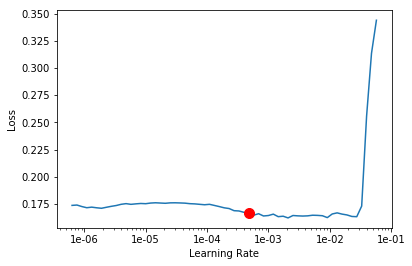

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,kappa_score,time
0,0.125636,0.130135,0.780694,0.785577,0.986715,0.720332,0.874732,0.938649,0.078393,01:37
1,0.124972,0.128122,0.787254,0.796644,0.974638,0.767269,0.876697,0.932948,0.155534,01:36
2,0.121137,0.112106,0.806935,0.830851,0.943237,0.800083,0.883484,0.918391,0.333562,01:35
3,0.110440,0.113817,0.812559,0.824380,0.963768,0.825670,0.888641,0.932243,0.318916,01:36
4,0.108525,0.115682,0.809747,0.814703,0.977053,0.833611,0.888523,0.939605,0.274609,01:35
5,0.109324,0.112569,0.813496,0.819939,0.973430,0.834940,0.890116,0.938300,0.302658,01:35


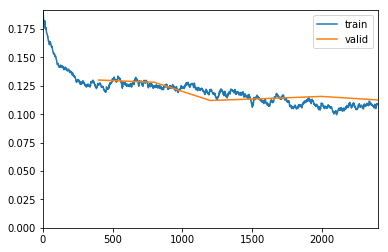

In [11]:
lr = 1e-3
learn.freeze()
learn.fit_one_cycle(6,slice(lr))
#learn.fit_one_cycle(1,1e-3)

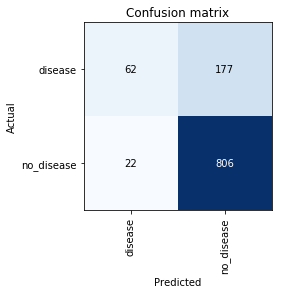

In [12]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze");

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.10E-07


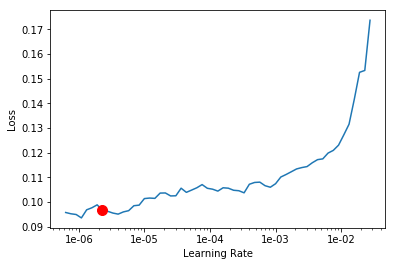

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,kappa_score,time
0,0.104500,0.111565,0.810684,0.821355,0.966184,0.834041,0.887902,0.933271,0.304258,02:08
1,0.101476,0.109037,0.815370,0.826267,0.964976,0.837189,0.890251,0.933629,0.330391,02:09
2,0.105861,0.116596,0.805061,0.813765,0.971014,0.835011,0.885463,0.934884,0.264001,02:09
3,0.104484,0.114129,0.818182,0.826804,0.968599,0.839205,0.892102,0.936478,0.336855,02:07
4,0.104649,0.107159,0.823805,0.834728,0.963768,0.844754,0.894619,0.934864,0.373904,02:06
5,0.099547,0.106716,0.820993,0.840642,0.949275,0.839746,0.891662,0.925359,0.387557,02:07
6,0.100849,0.105799,0.823805,0.833333,0.966184,0.849706,0.894855,0.936330,0.369266,02:07
7,0.105140,0.105640,0.820993,0.832811,0.962560,0.850767,0.892997,0.933474,0.362742,02:07
8,0.100036,0.105378,0.823805,0.837553,0.958937,0.850681,0.894144,0.931925,0.382979,02:05
9,0.100273,0.104349,0.825679,0.844421,0.950483,0.849696,0.894318,0.927191,0.406740,02:07


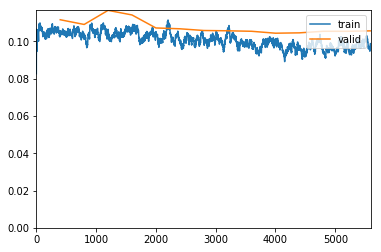

In [16]:
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))
lr = 1e-3
learn.fit_one_cycle(14, slice(1e-6,lr/5))
#learn.fit_one_cycle(1, lr, wd=1e-7)

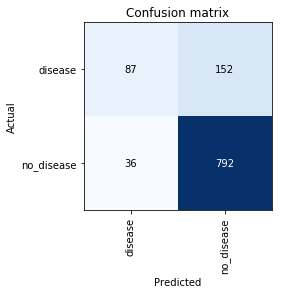

In [17]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [18]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

In [19]:
# Starting with image size 768
data = (src.transform(tfms, size=full_resolution)
           .databunch(bs=4, path='.').normalize(imagenet_stats))

In [20]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-04


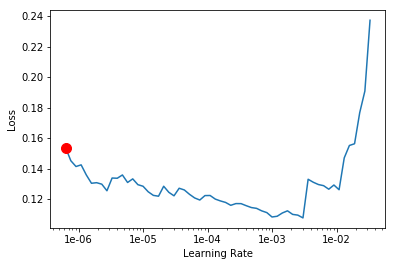

In [21]:

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,kappa_score,time
0,0.122967,0.100942,0.829428,0.872120,0.914251,0.847806,0.892689,0.905502,0.478287,07:09
1,0.123158,0.101581,0.830366,0.873988,0.913043,0.860141,0.893089,0.904956,0.483605,07:08
2,0.115098,0.105181,0.841612,0.848677,0.968599,0.852061,0.904681,0.941978,0.448336,06:31
3,0.112118,0.096517,0.851921,0.885057,0.929952,0.874194,0.906949,0.920612,0.545647,06:19
4,0.101858,0.094818,0.851921,0.895047,0.916667,0.881799,0.905728,0.912260,0.560979,06:19
5,0.091194,0.092204,0.853796,0.900000,0.913043,0.886327,0.906475,0.910405,0.571790,06:20


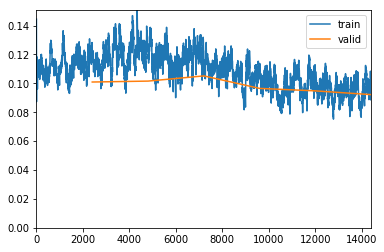

In [22]:
#learn.fit_one_cycle(10, 1e-6, wd=5e-6)
lr = 1e-3
learn.freeze()
learn.fit_one_cycle(6, slice(lr), wd=5e-6)
#learn.fit_one_cycle(1, slice(3e-3), wd=5e-6)

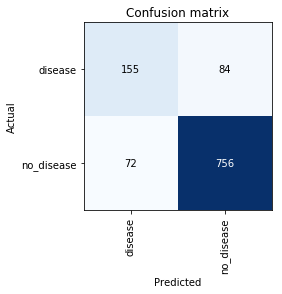

In [23]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_before_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [24]:
learn.unfreeze()
learn = learn.clip_grad();

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,kappa_score,time
0,0.102182,0.108298,0.848172,0.855011,0.968599,0.884985,0.908267,0.943529,0.477773,10:13
1,0.112250,0.127768,0.857545,0.872247,0.956522,0.891188,0.912442,0.938389,0.534842,10:11
2,0.156315,0.159931,0.852858,0.875700,0.944444,0.892462,0.908774,0.929846,0.531414,09:54
3,0.132268,0.180267,0.862231,0.886493,0.943237,0.887641,0.913985,0.931314,0.569766,10:09
4,0.164948,0.197584,0.858482,0.873208,0.956522,0.895761,0.912968,0.938611,0.538681,11:54
5,0.141789,0.206040,0.854733,0.875139,0.948068,0.891759,0.910145,0.932525,0.534314,11:49
6,0.130129,0.207460,0.866917,0.892448,0.942029,0.892648,0.916569,0.931677,0.589048,11:43
7,0.168042,0.200194,0.864105,0.885006,0.948068,0.893427,0.915452,0.934746,0.571466,11:23
8,0.136163,0.206242,0.866917,0.890661,0.944444,0.895013,0.916764,0.933174,0.586405,11:23
9,0.126456,0.203154,0.865042,0.887755,0.945652,0.894796,0.915789,0.933476,0.577865,11:22


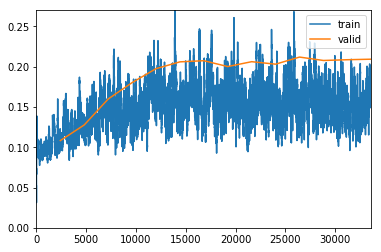

In [25]:
lr = 1e-3
learn.fit_one_cycle(14, slice(1e-6,lr/5))
#learn.fit_one_cycle(1, lr)
#learn.fit_one_cycle(5, slice(1e-6))

In [26]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")


In [ ]:
# BEST MODEL is loaded before running on test data
#learn.load(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")
learn.save(f"{exp_label}_pneumo_{full_resolution}_before_unfreeze")
#learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

In [56]:
sample_df = pd.read_csv('../sample_submission.csv')
sample_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [57]:
learn.data.add_test(ImageList.from_df(sample_df,f'../data{full_resolution}/',folder='test',suffix='.png'))

In [58]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
cls_pred = F.softmax(preds,1).argmax(1).cpu().numpy()

In [59]:
paths = list(map(str,list(learn.data.test_ds.x.items)))
all_test_paths = [p.split('/')[-1][:-4] for p in paths]

df_preds = pd.DataFrame()
df_preds['test_paths'] = all_test_paths
df_preds['class_pred'] = cls_pred

df_preds.set_index('test_paths',inplace=True)

In [60]:
df_preds.head()

,class_pred
test_paths,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,1
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,1


In [61]:
no_dis_idx = df_preds[df_preds.class_pred==1].index
print(len(no_dis_idx))

1173


In [50]:
sub = pd.read_csv('new_aug.csv',index_col=['ImageId'])
sub.head(25)
sub.fillna(value=' -1',inplace=True)
sub.head()


,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,-1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,-1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,562270 4 1019 6 1006 23 997 30 991 34 989 35 9...
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,-1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,-1


In [51]:
sub.loc[no_dis_idx] = ' -1'


In [52]:
sub.to_csv(f'{exp_label}_{model_name}_{half_resolution}_{full_resolution}_classifier_correction_before_unfreeze.csv')

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

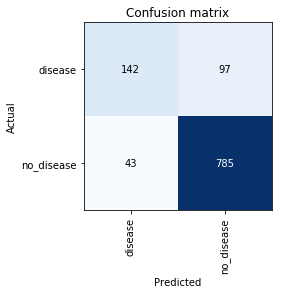

In [63]:
interp.plot_confusion_matrix()

In [55]:
interp.plot_top_losses(8, figsize=(14,14))

TypeError: len() of a 0-d tensor